Processing Names: 100%|██████████| 147269/147269 [44:55<00:00, 54.64it/s] 



🔍 **Randomly Selected Names and Their Classification Metrics:**
Name           Actual Gender  Final Predicted     CSV Lookup               Suffix                   Char-Freq                VCR                      
----------------------------------------------------------------------------------------------------------------------------------
madison-lee    F              F                   F (0.12)  M (0.50)  F (0.50)  F (0.50)
domonic        M              M                   M (0.48)  M (0.50)  F (0.50)  M (0.50)
braxsen        M              M                   M (0.45)  M (0.50)  F (0.50)  M (0.50)
susanto        M              M                   M (0.36)  M (0.50)  F (0.50)  M (0.50)
shaye          F              F                   F (0.23)  M (0.50)  F (0.50)  M (0.50)
kellyanne      F              F                   F (0.21)  M (0.50)  F (0.50)  M (0.50)
jayne          F              F                   F (0.23)  M (0.50)  F (0.50)  M (0.50)
lexia          F              

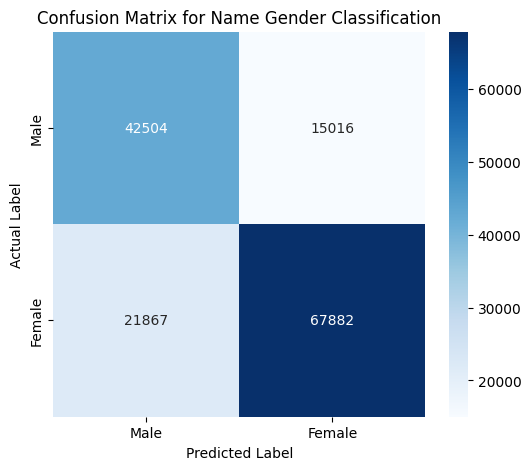


📊 **Final Dataset-Wide Metrics Report:**
✔ **Total Names Processed:** 147269
✔ **Overall Accuracy:** 74.96%


In [32]:
import pandas as pd
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

class NameGenderClassifier:
    def __init__(self, csv_file_path):
        self.df = pd.read_csv(csv_file_path)
        self.df["Name"] = self.df["Name"].str.lower()  # Ensure names are lowercase
        self.gender_map = {"M": "Male", "F": "Female"}

        max_prob = self.df["Probability"].max()
        self.df["Normalized_Prob"] = self.df["Probability"] / max_prob

        self.FEMALE_SUFFIXES = ["a", "ine", "ette", "elle", "iana", "ita", "isa"]
        self.MALE_SUFFIXES = ["o", "er", "an", "on", "us", "el", "is", "ric", "dan"]

        self.processed_data = []
        self.actual_labels = []
        self.predicted_labels = []

    def lookup_csv(self, name):
        matched_entries = self.df[self.df["Name"] == name]
    
        if not matched_entries.empty:
            male_count = matched_entries[matched_entries["Gender"] == "M"]["Count"].sum()
            female_count = matched_entries[matched_entries["Gender"] == "F"]["Count"].sum()
            total_count = male_count + female_count
    
            if male_count > female_count:
                return "Male", male_count / total_count, 0.0
            elif female_count > male_count:
                return "Female", 0.0, female_count / total_count
            else:
                return "Male", 0.5, 0.5
    
        return "Male", 0.5, 0.5




    def classify_by_suffix(self, name):
        for suffix in self.FEMALE_SUFFIXES:
            if name.endswith(suffix):
                return "Female", 1.0, 0
        for suffix in self.MALE_SUFFIXES:
            if name.endswith(suffix):
                return "Male", 0, 1.0
        return "Male", 0.5, 0.5  # Default to Male

    def classify_by_character_frequency(self, name):
        char_counts = Counter(name)
        prob_male = sum([char_counts[c] for c in "mrtdlh"]) / max(len(name), 1)
        prob_female = sum([char_counts[c] for c in "aeiou"]) / max(len(name), 1)

        if prob_male == prob_female:
            return "Male", 0.5, 0.5  # Default to Male
        return ("Male", prob_male, 0) if prob_male > prob_female else ("Female", 0, prob_female)

    def classify_by_vowel_consonant_ratio(self, name):
        char_counts = Counter(name)
        vowels = sum([char_counts[c] for c in "aeiou"])
        consonants = sum([char_counts[c] for c in "bcdfghjklmnpqrstvwxyz"])
        ratio = vowels / max((vowels + consonants), 1)  # Avoid division by zero

        return ("Female", 0, ratio) if ratio > 0.45 else ("Male", ratio, 0)

    def predict(self, name, actual_gender):
        name = name.lower().strip()
        results = {}
    
        results["CSV Lookup"], male_csv_prob, female_csv_prob = self.lookup_csv(name)
        results["Suffix-Based"], male_suffix_prob, female_suffix_prob = self.classify_by_suffix(name)
        results["Character Frequency"], male_char_prob, female_char_prob = self.classify_by_character_frequency(name)
        results["Vowel-Consonant Ratio"], male_vcr_prob, female_vcr_prob = self.classify_by_vowel_consonant_ratio(name)
    
        male_prob = sum([male_csv_prob, male_suffix_prob, male_char_prob, male_vcr_prob]) / 4
        female_prob = sum([female_csv_prob, female_suffix_prob, female_char_prob, female_vcr_prob]) / 4
    
        male_votes = sum([1 for method in results if results[method][0] == "Male"])
        female_votes = sum([1 for method in results if results[method][0] == "Female"])
    
        if male_votes > female_votes:
            final_prediction_mf = "M"
        elif female_votes > male_votes:
            final_prediction_mf = "F"
        else:
            final_prediction_mf = "M" if male_prob >= female_prob else "F"
    
        self.processed_data.append((name, actual_gender, final_prediction_mf, results, male_prob, female_prob))
        self.actual_labels.append(actual_gender)
        self.predicted_labels.append(final_prediction_mf)
    
        return final_prediction_mf


    def display_random_samples(self, num_samples=15):
        random_samples = random.sample(self.processed_data, min(num_samples, len(self.processed_data)))
    
        print("\n🔍 **Randomly Selected Names and Their Classification Metrics:**")
        print(f"{'Name':<15}{'Actual Gender':<15}{'Final Predicted':<20}{'CSV Lookup':<25}{'Suffix':<25}{'Char-Freq':<25}{'VCR':<25}")
        print("-" * 130)
    
        for name, actual_gender, final_pred, results, male_prob, female_prob in random_samples:
            csv_pred = results["CSV Lookup"]
            suffix_pred = results["Suffix-Based"]
            char_pred = results["Character Frequency"]
            vcr_pred = results["Vowel-Consonant Ratio"]
    
            csv_male_prob = float(male_prob) if isinstance(male_prob, (int, float)) else 0.5
            suffix_male_prob = float(suffix_pred[1]) if isinstance(suffix_pred[1], (int, float)) else 0.5
            char_male_prob = float(char_pred[1]) if isinstance(char_pred[1], (int, float)) else 0.5
            vcr_male_prob = float(vcr_pred[1]) if isinstance(vcr_pred[1], (int, float)) else 0.5
    
            print(f"{name:<15}{actual_gender:<15}{final_pred:<20}"
                  f"{csv_pred[0]} ({csv_male_prob:.2f})  {suffix_pred[0]} ({suffix_male_prob:.2f})  "
                  f"{char_pred[0]} ({char_male_prob:.2f})  {vcr_pred[0]} ({vcr_male_prob:.2f})")


    def evaluate(self):
        cm = confusion_matrix(self.actual_labels, self.predicted_labels, labels=["M", "F"])

        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Male", "Female"], yticklabels=["Male", "Female"])
        plt.xlabel("Predicted Label")
        plt.ylabel("Actual Label")
        plt.title("Confusion Matrix for Name Gender Classification")
        plt.show()

        accuracy = accuracy_score(self.actual_labels, self.predicted_labels)
        precision_m = precision_score(self.actual_labels, self.predicted_labels, pos_label="M")
        recall_m = recall_score(self.actual_labels, self.predicted_labels, pos_label="M")
        f1_m = f1_score(self.actual_labels, self.predicted_labels, pos_label="M")

        precision_f = precision_score(self.actual_labels, self.predicted_labels, pos_label="F")
        recall_f = recall_score(self.actual_labels, self.predicted_labels, pos_label="F")
        f1_f = f1_score(self.actual_labels, self.predicted_labels, pos_label="F")

        print("\n📊 **Final Dataset-Wide Metrics Report:**")
        print(f"✔ **Total Names Processed:** {len(self.actual_labels)}")
        print(f"✔ **Overall Accuracy:** {accuracy:.2%}")

csv_file = "names.csv"
classifier = NameGenderClassifier(csv_file)

for _, row in tqdm(classifier.df.iterrows(), total=len(classifier.df), desc="Processing Names"):
    classifier.predict(row["Name"], row["Gender"])

classifier.display_random_samples()
classifier.evaluate()
